<a href="https://colab.research.google.com/github/tsaw8/Thinkful_Project/blob/master/Product_Recommender_for_E_Commerce_Website_with_Implicit_Feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Recommendation for E-commerce Website
 
## Problem Description 
According to Statista, over 4.33 billion people access the internet globally. Many service providers and retailers have moved online and the popularity of ecommerce platforms continue to rise . Unlike physical stores, online retailers are not restricted to limited shelf space. Retailers are able to sell a wide variety of products online because the costs of logistics is lower. However, the huge amount of goods available makes it difficult for customers to navigate through their product of interest. To influence the user’s buying decision and increase the company’s revenue, we will create a product recommender system to provide a suggested list of items based on users history.
 
## Dataset Overview
For this project, we will be using the [Online Retail](http://archive.ics.uci.edu/ml/datasets/Online+Retail) dataset from the UCI Machine Learning repository. It contains transactional information of an online retail company based in the UK during a year period. The company sells unique all-occasion gifts. 
 
## Methodology
#### Data Preprocessing 
During data cleaning, we will filter out irrelevant information and use customer ids and product codes (stock code) to form a user-item matrix. Since we are only given implicit feedback of which items were purchased by customers the amount of quantity purchased will be used as the rating.
 
#### Model
Implicit library is a fast python collaborative filtering tool for implicit feedback. It also incorporates item and user properties of collaborative filtering into a matrix factorization to reduce dimensionality. We will be using the Alternating Least Squares model as discussed in [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf) by Hu, Koren, and Volinsky.
 
#### Evaluation 
We will use classification accuracy metrics, like ROC AUC, to assess the recommendation algorithm ability to classify relevant and irrelevant items. 



## Import the Dependencies 

In [1]:
!pip install -q implicit

     |████████████████████████████████| 1.1MB 3.3MB/s 


In [0]:
# Data manipulation  
import numpy as np
import pandas as pd 

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Pre-Processing 
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

# Modeling 
import implicit 

# Evaluation 
from sklearn import metrics

# Other
import random
from sklearn.preprocessing import MinMaxScaler

## Load the Data

In [0]:
# Import data
website_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
raw_data = pd.read_excel(website_url)

In [4]:
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


__Variable Description__ <br>
 * __InvoiceNo__: 6-digit integral number uniquely assigned to each transaction
  - code starts with letter ‘c’, it indicates a cancellation
 * __StockCode__: 5-digit integral number uniquely assigned to each distinct product
 * __Description__: quantities of each product (item) per transaction
 * __InvoiceDate__: day and time when each transaction was generated
 * __UnitPrice__: product price per unit in sterling
 * __CustomerID__: 5-digit integral number uniquely assigned to each customer
 * __Country__: name of the country where each customer resides

__Assumption__: Product price per unit is the same currency 

In [5]:
raw_data.shape

(541909, 8)

In [6]:
raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Missing Values¶
Now, we will take a look at missing values in each column.

In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(raw_data)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CustomerID,135080,24.9
Description,1454,0.3


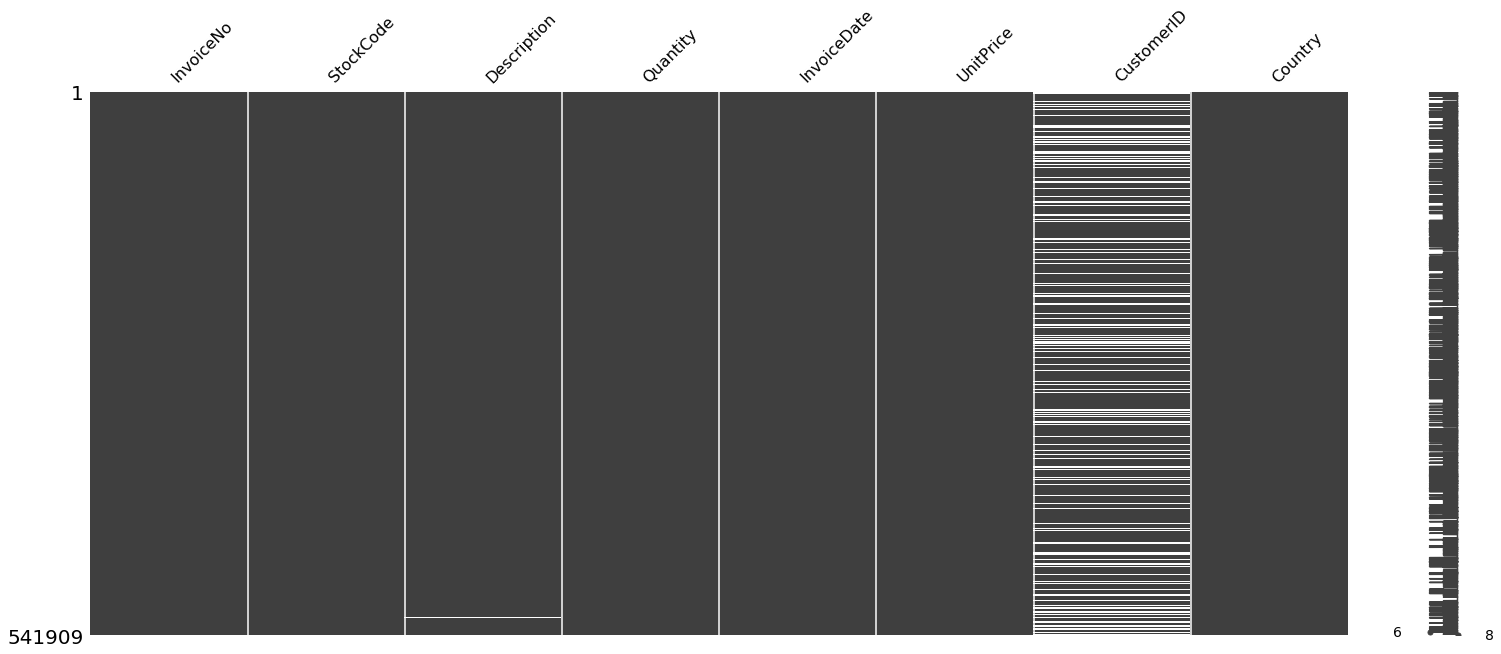

In [9]:
msno.matrix(raw_data)

__Observation__: As shown in the matrix, approximately 25% of customerIDs are missing. This might be due to the customer choosing to not logged in as a registered user. Customers might have also have cleared all website cookies so the server is unable to recognize the returning customer. In addition, the system wouldn't be able to recall new customers who do not have an associated customer ID.
 
Since we will use customerID information as user preference, we will all drop rows where customerID is missing.

In [0]:
# Return rows where customerID is not null
df = raw_data.loc[pd.isnull(raw_data.CustomerID) == False]

In [11]:
missing_values_table(df)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Format Data
Here, we will start cleaning the data by formatting the column names to lowercase. Variable data types will also be converted to their appropriate type.


In [12]:
# Format column names
df.rename(columns={'InvoiceNo': 'invoice_num',
                   'StockCode' : 'stock_code',
                   'Description' : 'description',
                   'Quantity' : 'quantity',
                   'InvoiceDate' : 'invoice_date',
                   'UnitPrice' : 'unit_price',
                   'CustomerID' : 'cust_id',
                   'Country' : 'country'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [13]:
# Convert cust_id from float to integer datatype
df['cust_id'] = df['cust_id'].astype('int64')

# Convert invoice_date format to Timestamp format
df['invoice_date'] = pd.to_datetime(df.invoice_date, format='%m/%d/%Y %H:%M')

# Apply lower case to description
df['description'] = df.description.str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [14]:
df.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,cust_id,country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [15]:
# Statistics
df.describe()

,quantity,unit_price,cust_id
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


__Observation:__ We can see that there are negative quantity values which probably represent cancellation invoices. Some unit price are zero. There could have been promotions where customers received free products. 

We'll remove negative quantity values since we are interested in exploring product sales. 

The min and max quantity is the negative and positive 80,995. This might have been a mistake and they customer returned all of the items after submitting the initial order. We will drop this outlier.

In [0]:
# Remove negative quantity
df = df[df.quantity >0 ]

In [0]:
# Drop max quantity
df = df.loc[df['quantity'] != 80995]

In [18]:
df.describe()

,quantity,unit_price,cust_id
count,397923.000000,397923.000000,397923.000000
mean,12.818312,3.116177,15294.312276
std,126.770157,22.096816,1713.171057
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,74215.000000,8142.750000,18287.000000


__Observation__: After filtering out negative quantities and the maximum value, the overall summary statistics for quantity did not vary by much. The average quantity per purchase remains to be around 12. The standard deviation did reduce from 248 items to 126 items. 

### Create New Features 
We'll create new variables to examine user preference and item sales. 




In [0]:
# Create amount spent
df['amount_spent'] = df['quantity'] * df['unit_price']

In [0]:
# Create year month of invoice 
df['year_month'] = df['invoice_date'].map(lambda x: 100*x.year + x.month)

# Month of invoice 
df['month'] = df['invoice_date'].dt.month

# Day of invoice 
df['day'] = (df['invoice_date'].dt.dayofweek)+1

# Hour of invoice 
df['hour'] = df['invoice_date'].dt.hour

In [21]:
df.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,amount_spent,year_month,month,day,hour
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,201012,12,3,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012,12,3,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,201012,12,3,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012,12,3,8
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012,12,3,8


In [22]:
# Exploring the unique values of each attribute
print("Number of transactions: ", df['invoice_num'].nunique())
print("Number of products: ",df['stock_code'].nunique())
print("Number of customers:", df['cust_id'].nunique() )
print('Number of countries: ', df['country'].nunique())

Number of transactions:  18535
Number of products:  3664
Number of customers: 4339
Number of countries:  37


# Exploratory Data Analysis
In this section, we will explore patterns and trends with the data. First, let's take a look into customer behavior. 

### Examine Customer Purchase History

__How many orders were made by customers?__

In [23]:
user_freq = df[['cust_id', 'stock_code']].groupby('cust_id').count().reset_index()
user_freq.columns = ['cust_id', 'quantity']
user_freq.head()

,cust_id,quantity
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [24]:
mean_n_purchase = user_freq['quantity'].mean()
print(f"Mean number of items purchased by a given user: {mean_n_purchase:.2f}.")

Mean number of items purchased by a given user: 91.71.


__Observation__: On average, customers purchased 91 items during the collection period.

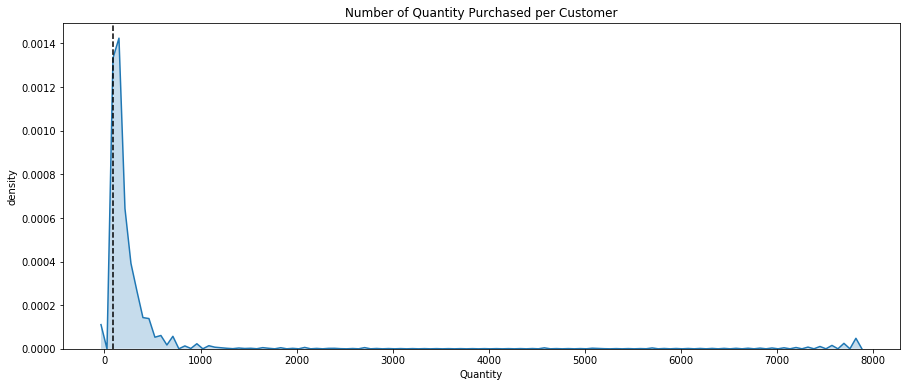

In [25]:
# Distribution of Quantity Purchased
plt.subplots(figsize=(15,6))
ax = sns.kdeplot(user_freq['quantity'], shade=True, legend=False)
ax.set(title="Number of Quantity Purchased per Customer", xlabel="Quantity", ylabel="density")
plt.axvline(user_freq['quantity'].mean(), color="k", linestyle="--")
plt.show()

__Observation__: On average, a customer will purchase 91 items in a transaction. However, this number is highly right skewed due to some few outliers. 

__Who are the top customers with the most numbers of orders?__

In [26]:
orders = df.groupby(by=['cust_id','country'], as_index=False)['invoice_num'].count()
orders.sort_values(by='invoice_num', ascending=False).head()

,cust_id,country,invoice_num
4019,17841,United Kingdom,7847
1888,14911,EIRE,5677
1298,14096,United Kingdom,5111
334,12748,United Kingdom,4596
1670,14606,United Kingdom,2700


__Observation__: UK customers appears to make the most purchases. 

NOTE: EIRE is Irish word for Ireland.

__Which customer spent the most money?__

In [27]:
money_spent = df.groupby(by=['cust_id','country'], as_index=False)['amount_spent'].sum()
money_spent.sort_values(by='amount_spent', ascending=False).head()

,cust_id,country,amount_spent
1698,14646,Netherlands,280206.02
4210,18102,United Kingdom,259657.30
3737,17450,United Kingdom,194550.79
1888,14911,EIRE,143825.06
57,12415,Australia,124914.53


__Observation__: Although most of the company's clients reside in the UK, a customer from the Netherlands made the highest purchase amount of 280,206 pounds. 

__How many orders per month?__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


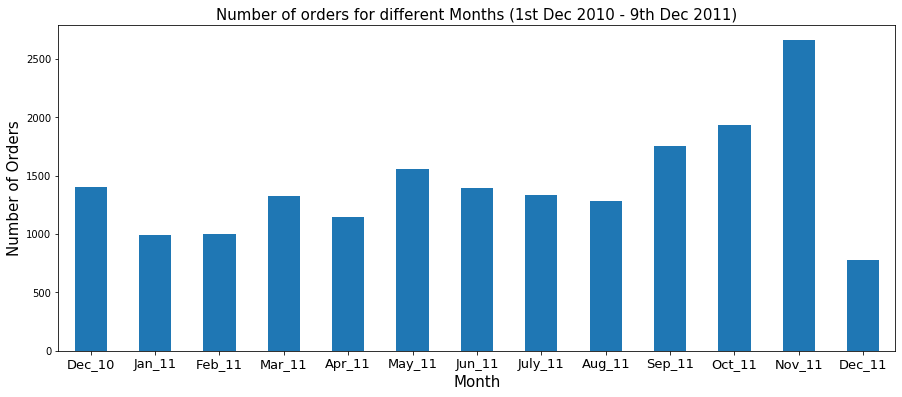

In [28]:
ax = df.groupby('invoice_num')['year_month'].unique().value_counts().sort_index().plot('bar',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11',
                    'May_11','Jun_11','July_11','Aug_11','Sep_11',
                    'Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()


__Observation__: In November 2011, the company experience the highest amount of orders. This might have been due to a promotional deal of free items, which is later explored in the examine item section. 

__How many ordes per day?__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


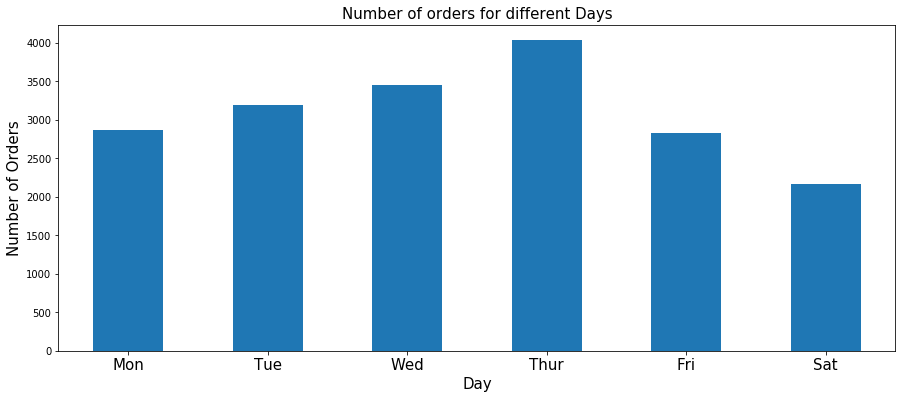

In [29]:
ax = df.groupby('invoice_num')['day'].unique().value_counts().sort_index().plot('bar',figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed',
                    'Thur','Fri','Sat','Sun'), rotation='horizontal', fontsize=15)
plt.show()

__Observation__: It appears that orders are made mainly during weekdays.  

__How many orders per hour?__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


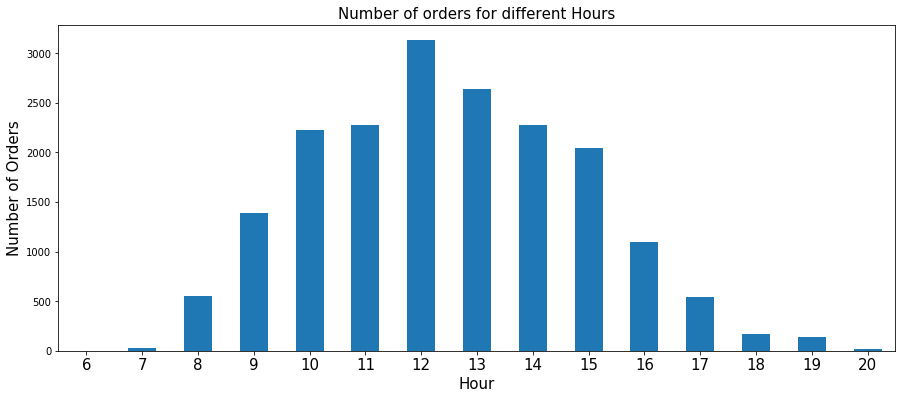

In [30]:
ax = df.groupby('invoice_num')['hour'].unique().value_counts().iloc[:-1].sort_index().plot('bar',figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

__Observation__: Customers make their order requests during typical 8-5 business hours. 

### Examine Unit Price
Let's take a look into the free items wiht unit price = 0.

In [0]:
df_free = df[df.unit_price == 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


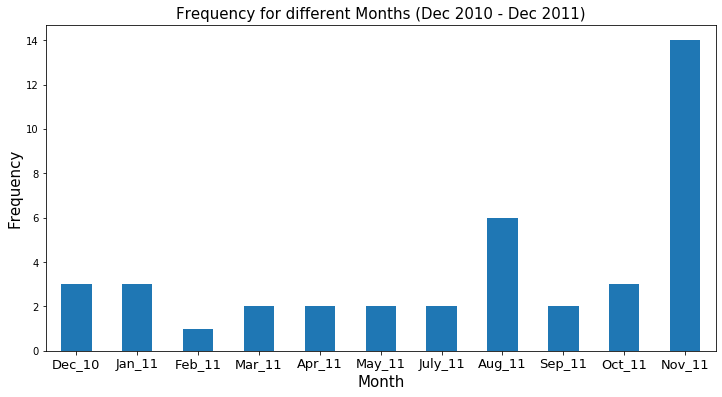

In [32]:
ax = df_free.year_month.value_counts().sort_index().plot('bar',figsize=(12,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11',
                    'Apr_11','May_11','July_11','Aug_11',
                    'Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()


__Observation__: The store must had a special promotion which caused overall orders to rise in November 2011.

### Examine Country

__How many orders for each country?__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """


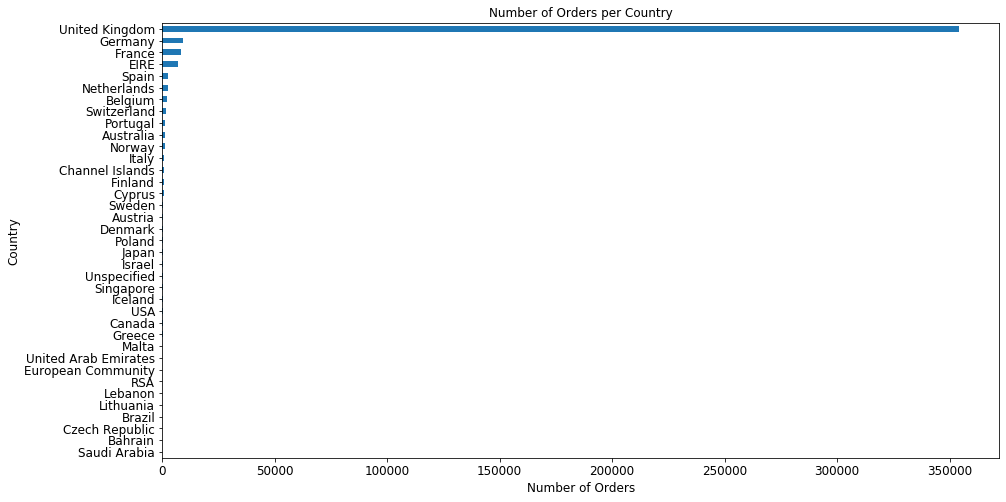

In [33]:
group_country_orders = df.groupby('country')['invoice_num'].count().sort_values()

# plot number of unique customers in each country 
plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders per Country', fontsize=12)
plt.show()

__Observation__: As expected, most orders are made in the UK.

__Revenue from each country__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """


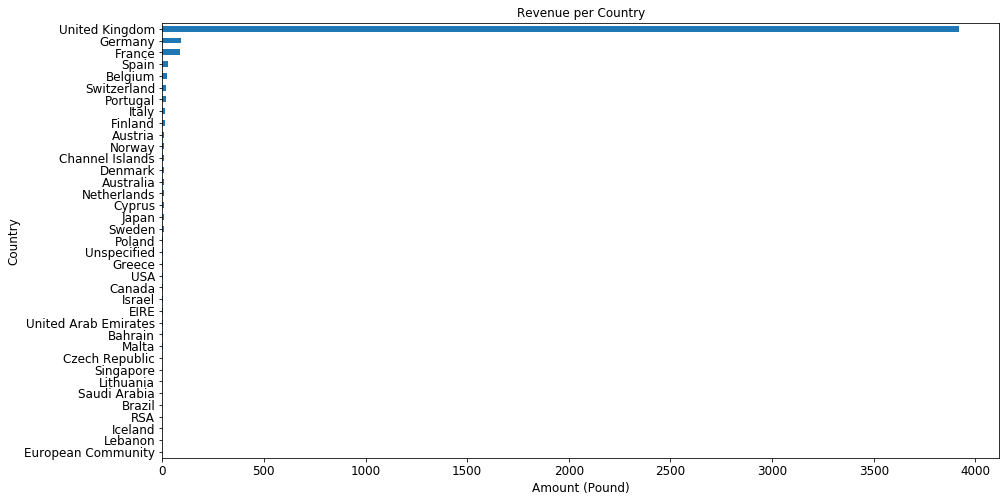

In [34]:
group_country_spent = money_spent.groupby('country')['amount_spent'].count().sort_values()

# plot number of unique customers in each country 
plt.subplots(figsize=(15,8))
group_country_spent.plot('barh', fontsize=12)
plt.xlabel('Amount (Pound)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Revenue per Country', fontsize=12)
plt.show()

__Observation__: Although EIRE customers rank 4th in orders, other countries like Spain and Belgium spend more on orders. 

### Exploring Product Trends

__Which products are best sellers?__

In [35]:
group_product = df.groupby(['stock_code','description', 'unit_price'],as_index= False)['quantity'].sum().sort_values(by='quantity', ascending=False)
group_product.head(10)

,stock_code,description,unit_price,quantity
5155,23166,medium ceramic top storage jar,1.04,76087
6699,84077,world war 2 gliders asstd designs,0.29,27528
6698,84077,world war 2 gliders asstd designs,0.21,23904
2457,22197,popcorn holder,0.72,22940
6893,84879,assorted colour bird ornament,1.69,22106
8318,85123A,white hanging heart t-light holder,2.55,19966
4930,23084,rabbit night light,1.79,19961
8291,85099B,jumbo bag red retrospot,1.79,19136
801,21212,pack of 72 retrospot cake cases,0.55,17534
3222,22492,mini paint set vintage,0.65,16888


__Observation__: Art materials and ornaments are popular product catrgories. 

__Which product did customers spend the most on?__

In [36]:
group_product_spent = df.groupby(['stock_code','description','unit_price'],
                                 as_index= False)['amount_spent'].sum().sort_values(by='amount_spent',ascending=False)
group_product_spent.head(10)

,stock_code,description,unit_price,amount_spent
3031,22423,regency cakestand 3 tier,10.95,93064.05
5155,23166,medium ceramic top storage jar,1.04,79130.48
8318,85123A,white hanging heart t-light holder,2.55,50913.30
3032,22423,regency cakestand 3 tier,12.75,48934.50
3245,22502,picnic basket wicker 60 pieces,649.50,39619.50
6893,84879,assorted colour bird ornament,1.69,37359.14
8894,POST,postage,18.00,36468.00
4930,23084,rabbit night light,1.79,35730.19
665,21137,black record cover frame,3.39,35161.08
8291,85099B,jumbo bag red retrospot,1.79,34253.44


__Observation__: A cake stand is highest revenue item since it's unit price is 10 times more than the best selling item (medium ceramic top storage jar). 

# Pre-processing Data
Before we can build a recommender model using ALS, we must create a user-item matrix. Each unique customer ID will be a row in the matrix and each unique item ID (stock code) will be the columns. The values in the matrix will reflect the total number of purchases by each customer per item.

Code from [Recommender System](https://jessesw.com/Rec-System/)

In [37]:
# Get rid of unnecessary info
cleaned_df = df.loc[:,['stock_code', 'quantity', 'cust_id']]

# Group together
grouped_cleaned = cleaned_df.groupby(['cust_id', 'stock_code']).sum().reset_index()

# Replace a sum of zero purchases with a one to
grouped_cleaned.quantity.loc[grouped_cleaned.quantity == 0] = 1 

# Only get customers where purchase totals were positive
grouped_purchased = grouped_cleaned.query('quantity > 0')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
grouped_purchased.head()

,cust_id,stock_code,quantity
0,12346,23166,74215
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


In [0]:
# Get our unique customers
customers = list(np.sort(grouped_purchased.cust_id.unique())) 
# Get our unique products that were purchased
products = list(grouped_purchased.stock_code.unique()) 
# All of our purchases
quantity = list(grouped_purchased.quantity) 

rows = grouped_purchased.cust_id.astype('category').cat.codes 
# Get the associated row indices
cols = grouped_purchased.stock_code.astype('category').cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, 
                                      (rows, cols)), shape=(len(customers), len(products)))

In [40]:
purchases_sparse

<4339x3664 sparse matrix of type '<class 'numpy.int64'>'
	with 266801 stored elements in Compressed Sparse Row format>

Let's check how sparse the matrix is.

In [41]:
# Number of possible interactions in the matrix
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] 
# Number of items interacted with
num_purchases = len(purchases_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

98.32180532813489

__Observation__: Majority of the matrix is sparse. However, collaborative filtering only requires 0.5% of data to produce decent results. 

## Create Train and Test
Since we are unable to deploy the recommender model and get user feedback, we will have to create a train and test set to evaluation the performance of our model. In the training set, a portion of the user-item interaction will be randomly mask with a zero, indicating that the user never purchased the item. The test set will contain the unaltered cells so we can if the items recommended were actually purchased. 

In [0]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original 
    ratings, while the training set replaces the specified percentage of them with a zero in the original ratings 
    matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    # Make a copy of the original set to be the test set. 
    test_set = ratings.copy() 
    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1 
    # Make a copy of the original data we can alter as our training set. 
    training_set = ratings.copy() 
    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero() 
    # Zip these pairs together of user,item index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 
    # Set the random seed to zero for reproducibility
    random.seed(0) 
    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) 
    # Sample a random number of user-item pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples) 
    # Get the user row indices
    user_inds = [index[0] for index in samples] 
    # Get the item column indices
    item_inds = [index[1] for index in samples] 
    # Assign all of the randomly chosen user-item pairs to zero
    training_set[user_inds, item_inds] = 0 
    # Get rid of zeros in sparse array storage after update to save space
    training_set.eliminate_zeros() 
    # Output the unique list of user rows that were altered 
    return training_set, test_set, list(set(user_inds))  

This will return our training set, a test set that has been binarized to 0/1 for purchased/not purchased, and a list of which users had at least one item masked. We will test the performance of the recommender system on these users only. I am masking 20% of the user/item interactions for this example.

In [0]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, 
                                                                pct_test = 0.2)

# Modeling
 
### Previous Work
 
__Neighborhood Models__ <br>
In collaborative filtering, neighborhood models are commonly used to estimate unknown ratings based on similar users historical data. However, these models are not able to distinguish between user preference and the confidence for those preferences with implicit feedback.  
 
__Latent Factor Models__ <br>
Latent factor models provide a more holistic approach to uncovering latent features that explain observed ratings. Singular value decomposition has been used to associate each user with a user-factor vector and each item with an item-factors vector. Predictions are done by the inner dot product of the reduced matrix. Parameters are
often learnt by stochastic gradient descent.
 
### Alternating Least Squares 
This approach is similar to latent factor methods in terms of model formulation and optimization technique. This model is based on the notion of a confidence matrix. Given binary variables as a zero represents no preference and one indicates high preference for the item, there are associated confidence levels for each preference. This way, we have some minimal confidence for every user-item pair, but as we observe more evidence for positive preference, our confidence increases accordingly. Like latent models, the algorithm decomposes the original user-item matrix into a user vector and item vector. We alternate between re-computing user-factors and item factors to minimize the difference between the product of our factor matrices and the original ratings matrix.



In [44]:
#Building the model
alpha = 15
model = implicit.als.AlternatingLeastSquares(factors=32, 
                                             regularization = 0.1, iterations = 50)
data = (product_train.T * alpha).astype('double')
model.fit(data)

In [0]:
user_vecs = model.user_factors
item_vecs = model.item_factors

# Evaluating the Recommender System
Since 20% of the training set was masked, we can evaluate the performance of the recommender model by seeing how many recommended items were purchased. Receiver Operating Characteristic (or ROC) curve can be used to if relevant items were properly classified and recommended. 

In [0]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)  

In [0]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item 
    interactions there were originally zero to test ranking ability in addition to the most popular items 
    as a benchmark.
    '''
    
    # An empty list to store the AUC for each user that had an item removed from the training set
    store_auc = [] 
    # To store popular AUC scores
    popularity_auc = [] 
    # Get sum of item iteractions to find most popular
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) 
    item_vecs = predictions[1]
    # Iterate through each user that had an item altered
    for user in altered_users: 
        # Get the training set row
        training_row = training_set[user,:].toarray().reshape(-1) 
        # Find where the interaction had not yet occurred
        zero_inds = np.where(training_row == 0) 
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        # Get the item popularity for our chosen items
        pop = pop_items[zero_inds] 
        # Calculate AUC for the given user and store
        store_auc.append(auc_score(pred, actual)) 
        # Calculate AUC using most popular and score
        popularity_auc.append(auc_score(pop, actual)) 
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [48]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)
# AUC for our recommender system

(0.871, 0.813)

__Observation__: We have a decent model that is able to recommend relevant items better than random guessing. 

Let's see if we can improve the score with hyperparameter tuning. 

### Cross-validation: Grid search
Now that the data is split into training and test matrices, let’s run a giant grid search to optimize our hyperparameters. We have four parameters that we would like to optimize:

 * num_factors: The number of latent factors, or degree of dimensionality in our model.
 * regularization: Scale of regularization for both user and item factors.
 * alpha: Our confidence scaling term.
 * iterations: Number of iterations to run Alternating Least Squares optimization

 Reference link: [here](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

 __NOTE:__ Unable to run the Gridsearch code from scratch so we'll do optimization manually.

In [0]:
param_grid = {'num_factors': [32, 40],
              'regularization': [0.0, 0.1, 0.5],
              'alpha': [1, 15, 20]}

__Hyperparameter Tuning 1: Alpha__ <br>
 

Result:
 - alpha 1: (0.851, 0.813)
 - __alpha 15__: (0.871, 0.813)
 - alpha 20: (0.868, 0.813)

We'll continue with an alpha value of 15.


In [49]:
#Building the model
alpha1 = 1
gs1_model = implicit.als.AlternatingLeastSquares(factors=32, 
                                                 regularization = 0.1, iterations = 50)
data = (product_train.T * alpha1).astype('double')
gs1_model.fit(data)

In [0]:
user_vecs1 = gs1_model.user_factors
item_vecs1 = gs1_model.item_factors

In [51]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs1), sparse.csr_matrix(item_vecs1.T)], product_test)
# AUC for our recommender system

(0.851, 0.813)

Since the ROC score decreased, let's try increasing the alpha value.

In [52]:
#Building the model
alpha2 = 20
gs2_model = implicit.als.AlternatingLeastSquares(factors=32, 
                                                 regularization = 0.1, iterations = 50)
data = (product_train.T * alpha2).astype('double')
gs2_model.fit(data)

In [0]:
user_vecs2 = gs2_model.user_factors
item_vecs2 = gs2_model.item_factors

In [54]:
# AUC for our recommender system
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs2), sparse.csr_matrix(item_vecs2.T)], product_test)

(0.868, 0.813)

__Hyperparameter Tuning 2: Factors__ <br>


Result:  
 - __factor 32__: (0.871, 0.813)
 - factor 40: (0.857, 0.813)



In [55]:
#Building the model
alpha = 15
gs3_model = implicit.als.AlternatingLeastSquares(factors=40, 
                                                 regularization = 0.1, iterations = 50)
data = (product_train.T * alpha).astype('double')
gs3_model.fit(data)

In [0]:
user_vecs3 = gs3_model.user_factors
item_vecs3 = gs3_model.item_factors

In [57]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs3), sparse.csr_matrix(item_vecs3.T)], product_test)
# AUC for our recommender system

(0.857, 0.813)

We'll stop here with this step since the system does not recommend decreasing the number of factor below 32.

__Hyperparameter Tuning 3: Regularization__

Result:
 - regularization 0: (0.869, 0.813)
 - __regularization 0.1__: (0.871, 0.813)
 - regularization 0.5: (0.869, 0.813)

In [58]:
#Building the model
alpha = 15
gs4_model = implicit.als.AlternatingLeastSquares(factors=32, 
                                                 regularization = 0, iterations = 50)
data = (product_train.T * alpha).astype('double')
gs4_model.fit(data)

In [0]:
user_vecs4 = gs4_model.user_factors
item_vecs4 = gs4_model.item_factors

In [60]:
# AUC for our recommender system
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs4), sparse.csr_matrix(item_vecs4.T)], product_test)

(0.869, 0.813)

Let's try increasing the regularization then. 

In [61]:
#Building the model
alpha = 15
gs5_model = implicit.als.AlternatingLeastSquares(factors=32, 
                                                 regularization = 0.5, iterations = 50)
data = (product_train.T * alpha).astype('double')
gs5_model.fit(data)

In [0]:
user_vecs5 = gs5_model.user_factors
item_vecs5 = gs5_model.item_factors

In [63]:
# AUC for our recommender system
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs5), sparse.csr_matrix(item_vecs5.T)], product_test)

(0.869, 0.813)

Overall, we were unable to select hyperparameter tuning to improve the auc score of 0.87.

# A Recommendation Example
Let's test our model out with different customer IDs. 

In [0]:
# Only get unique item/description pairs
item_lookup = df.loc[:,['stock_code', 'description']].drop_duplicates() 

# Encode as strings for future lookup ease
item_lookup['stock_code'] = item_lookup['stock_code'].astype(str)

In [65]:
item_lookup.head()

,stock_code,description
0,85123A,white hanging heart t-light holder
1,71053,white metal lantern
2,84406B,cream cupid hearts coat hanger
3,84029G,knitted union flag hot water bottle
4,84029E,red woolly hottie white heart.


In [0]:
# Array of customer IDs from the ratings matrix
customers_arr = np.array(customers) 
# Array of product IDs from the ratings matrix
products_arr = np.array(products) 

In [0]:
def get_items_purchased(customer_id, mf_train, customers_list, products_list, item_lookup):
    '''
    This just tells me which items have been already purchased by a specific user in the training set. 
    
    parameters: 
    
    customer_id - Input the customer's id number that you want to see prior purchases of at least once
    
    mf_train - The initial ratings training set used (without weights applied)
    
    customers_list - The array of customers used in the ratings matrix
    
    products_list - The array of products used in the ratings matrix
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    returns:
    
    A list of item IDs and item descriptions for a particular customer that were already purchased in the training set
    '''
    # Returns the index row of our customer id
    cust_ind = np.where(customers_list == customer_id)[0][0] 
    # Get column indices of purchased items
    purchased_ind = mf_train[cust_ind,:].nonzero()[1] 
    # Get the stock codes for our purchased items
    prod_codes = products_list[purchased_ind] 
    return item_lookup.loc[item_lookup.stock_code.isin(prod_codes)]

In [68]:
customers_arr[:5]

array([12346, 12347, 12348, 12349, 12350])

In [0]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    This function will return the top recommended items to our users 
    
    parameters:
    
    customer_id - Input the customer's id number that you want to get recommendations for
    
    mf_train - The training matrix you used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_vecs - the item vectors from your fitted matrix factorization
    
    customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    item_list - an array of the products that make up the columns of your ratings matrix
                    (in order of matrix)
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    num_items - The number of items you want to recommend in order of best recommendations. Default is 10. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    # Returns the index row of our customer id
    cust_ind = np.where(customer_list == customer_id)[0][0] 
    # Get the ratings from the training set ratings matrix
    pref_vec = mf_train[cust_ind,:].toarray() 
    # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec = pref_vec.reshape(-1) + 1 
    # Make everything already purchased zero
    pref_vec[pref_vec > 1] = 0 
    # Get dot product of user vector and all item vectors
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) 
   
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    
    # Items already purchased have their recommendation multiplied by zero
    # Sort the indices of the items into order
    product_idx = np.argsort(recommend_vector)[::-1][:num_items]  
    
    # of best recommendations
    # start empty list to store items
    rec_list = [] 
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.description.loc[item_lookup.stock_code == code].iloc[0]]) 
        # Append our descriptions to the list
    
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    # Create a dataframe
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions})
    # Switch order of columns around
    return final_frame[['StockCode', 'Description']] 

In [72]:
get_items_purchased(12346, product_train, customers_arr, products_arr, item_lookup)

,stock_code,description
31495,22258,felt farm animal rabbit


In [73]:
rec_items(12346, product_train, user_vecs, item_vecs, customers_arr, 
          products_arr, item_lookup, num_items = 10)


,StockCode,Description
0,22761,chest 7 drawer ma campagne
1,22264,felt farm animal white bunny
2,22247,bunny decoration magic garden
3,21654,ridged glass finger bowl
4,22694,wicker star
5,84678,classical rose small vase
6,22425,enamel colander cream
7,22393,paperweight vintage collage
8,22419,lipstick pen red
9,22782,set 3 wicker storage baskets


__Observation__: Customer 12346 purchased a felt farm animal product. The system recommended other felt and farm animals products. The first 3 items seem more relevant than the lower half of the list.

Let's try another customer.

In [74]:
get_items_purchased(12353, product_train, customers_arr, products_arr, item_lookup)

,stock_code,description
1087,21826,eight piece dinosaur set
3637,21158,moody girl door hanger
9102,21865,pink union jack passport cover
231161,23125,6pc wood plate set disposable


In [75]:
rec_items(12353, product_train, user_vecs, item_vecs, customers_arr, 
          products_arr, item_lookup,num_items = 10)

,StockCode,Description
0,84946,antique silver tea glass etched
1,85071B,red charlie+lola personal doorsign
2,22559,seaside flying disc
3,84598,boys alphabet iron on patches
4,21065,boom box speaker girls
5,22190,local cafe mug
6,22191,ivory diner wall clock
7,23186,french style storage jar cafe
8,35912B,white/pink chick decoration
9,84879,assorted colour bird ornament


__Observation__: The recommender system appears to be performing well. Customer 12353 had purchased a variety of items such as a door hanger and a wood plate set. The recommender suggested other kitchenware like cups and other door ornaments. 


# Conclusion 
In this project, we have created a recommender system that takes in implicit feedback and produces a list of items similar to what the customer has purchased. We take an alternating least square approach that performs matrix factorization and minimize the cost function by solving one feature vector at a time. This enables it to run in parallel and makes it less computational expensive than singular value decomposition. Then, we were able to evaluate our recommender system by how well it was able to classify relevant items that were purchased with an ROC AUC score. 
 
Although we were able to design a decent recommender, there are a couple of shortcomings that we were unable to address. Deploying an implicit model and fitting a single user-item matrix in one machine would be too memory intensive. A more practical method would be to implement it through Spark. In addition, our model is not equipped to resolve the cold start problem since we do not have previous user history. A hybrid approach would be able to incorporate feature properties and produce recommend similar items without user data. 
 
In future work, we could strive to improve customer experience on the website by performing customer segmentation. By doing so, we would be able to uncover insightful behavior patterns that can allow us to create a set of personalized systems for each tier of customers. For example, if the customer runs an art and crafts shop, he might be interested in viewing newly released art supplies. This way, the system is able to learn about user perference and allow exposure of new products.

